In [1]:
import os
import re
import sys
import phik
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)
warnings.filterwarnings('ignore')

In [3]:
def showMissing(df):
    """ Show features with missing values """
    nullOrd = df.isnull().sum().sort_values(ascending=False)
    nullOrd = nullOrd[nullOrd > 0]
    nullOrd = pd.DataFrame(nullOrd, columns=['TotalNA'])
    nullOrd['PropNA'] = nullOrd['TotalNA'] / len(df)
    return nullOrd

In [4]:
train = 'train.csv'
test = 'test.csv'
index = 'PassengerId'
target = 'Survived'

In [5]:
dtypes = ({
    'Survived': bool, 
    'Pclass':   int, 
    'Name':     str,
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})
data = pd.read_csv(train, index_col=index, dtype=dtypes)

### Missing values in training data

In [122]:
missingVals = showMissing(data)
print(missingVals)

          TotalNA    PropNA
Cabin         687  0.771044
Age           177  0.198653
Embarked        2  0.002245


### Engineering Deck from Cabin number.
 - The first letter of the Cabin number represents the deck so we will extract.

In [115]:
data['Deck'] = data['Cabin'].apply(lambda x: x[0])

### Engineering Title from Name
 - We can gain from information from the Name feature but extracting the Title.
 - We find that 4 titles dominate, and group all others together.

In [111]:
data['Title'] = data['Name'].apply(lambda x: re.split(',|\.', x)[1].strip())

# Check frequency of each title.
print(data['Title'].value_counts())

# Replace non-standard titles with other to reduce cardinality.
data['Title'].loc[~data['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])] = 'Other'

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Lady              1
Ms                1
Capt              1
Sir               1
Jonkheer          1
Mme               1
Don               1
the Countess      1
Name: Title, dtype: int64


In [112]:
# Check cardinality of each feature
data.apply(pd.Series.nunique).sort_values(ascending=False)

Name        891
Ticket      681
Fare        248
Cabin       147
Age          88
Deck          8
Parch         7
SibSp         7
Title         5
Embarked      3
Pclass        3
Sex           2
Survived      2
dtype: int64

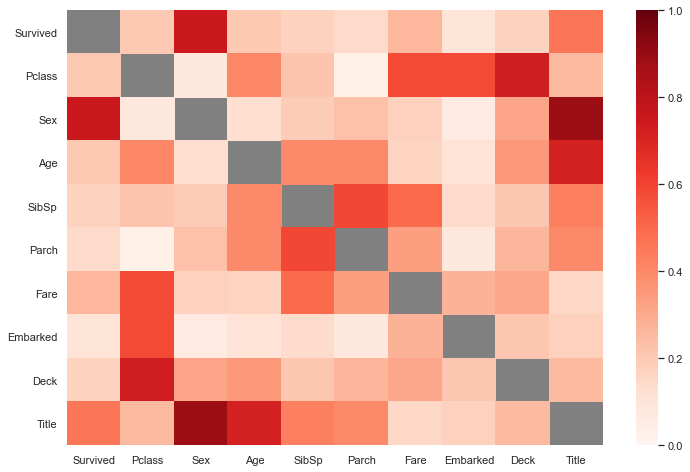

In [113]:
fig, ax = plt.subplots()
intervalCols = ['Age', 'Fare']
dropCols = ['Name', 'Ticket', 'Cabin']
phik = data.drop(dropCols, axis=1).phik_matrix(interval_cols=intervalCols)
g = sns.heatmap(phik, cmap='Reds', vmin=0, vmax=1, mask=(phik==1), ax=ax)
g.set_facecolor('grey')

In [577]:
allCorrelations = computeCorrelation(data)

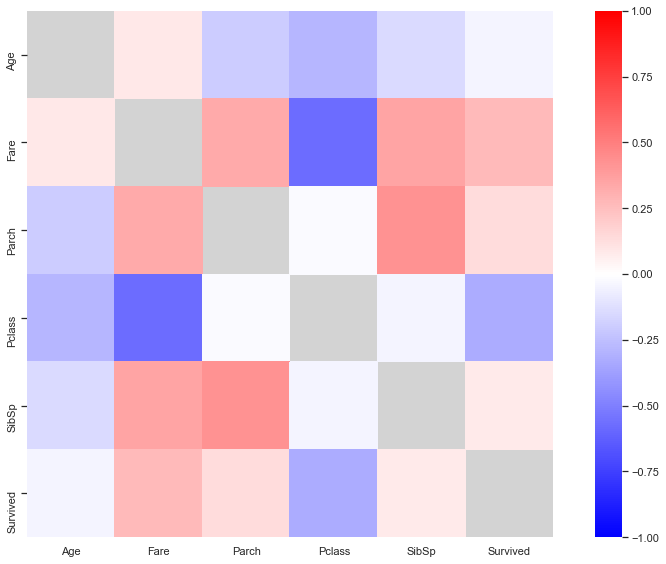

In [578]:
fig, ax = plotPairwiseCorrelation(allCorrelations)

(<Figure size 864x576 with 4 Axes>, (<AxesSubplot:>, <AxesSubplot:>))

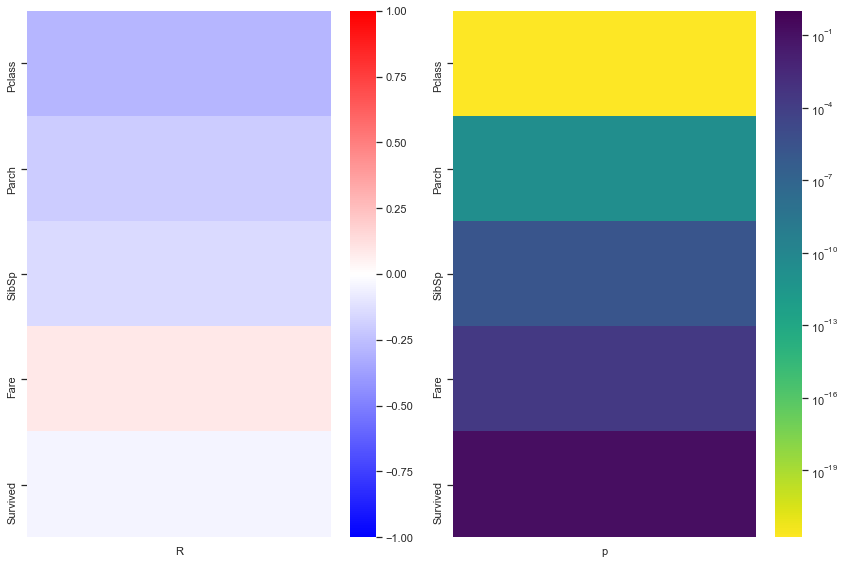

In [580]:
plotTargetCorrelation(allCorrelations, 'Age')

In [582]:
data['FamSize'] = data['Parch'] + data['SibSp']
data['Alone'] = data['FamSize'] == 1
data.groupby(['Sex', 'Pclass'])[['Survived']].agg(['count', 'mean'])

Survived          
                 count      mean
Sex    Pclass                   
female 1            94  0.968085
       2            76  0.921053
       3           144  0.500000
male   1           122  0.368852
       2           108  0.157407
       3           347  0.135447

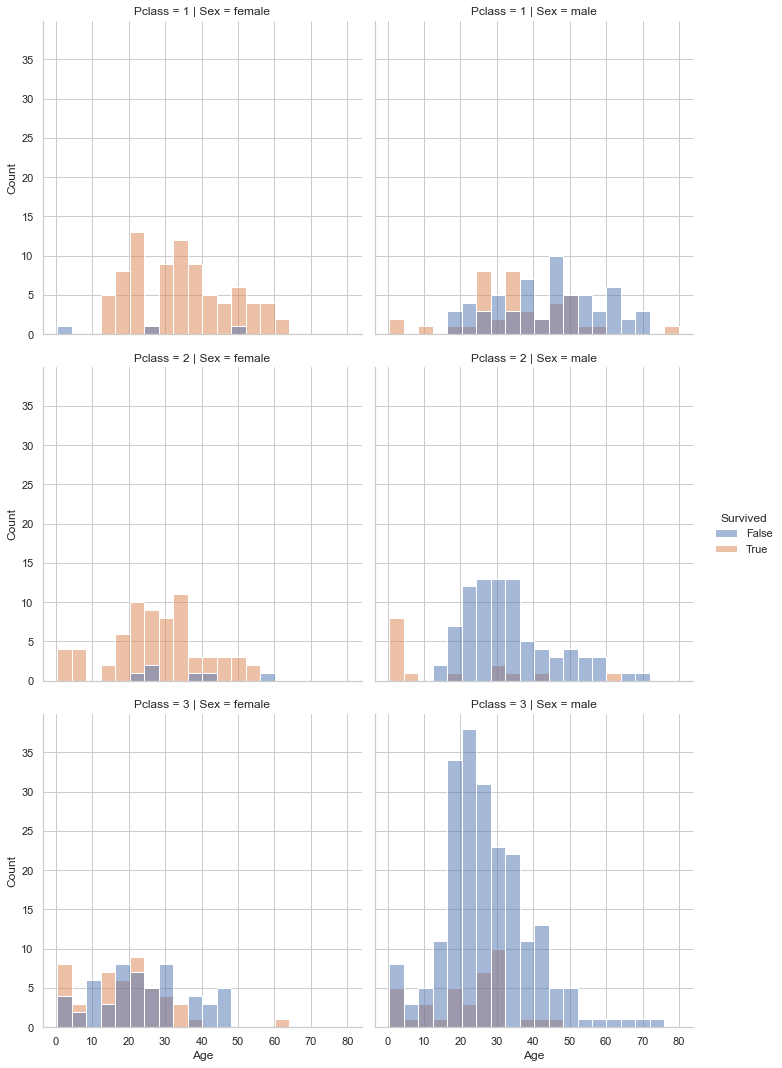

In [583]:
sns.displot(x='Age', hue='Survived', col='Sex', row='Pclass', kind='hist', data=data)

### Exploring Parch vs Survived
  - Parch feature indicates number of parents/children.

<AxesSubplot:xlabel='Parch', ylabel='Density'>

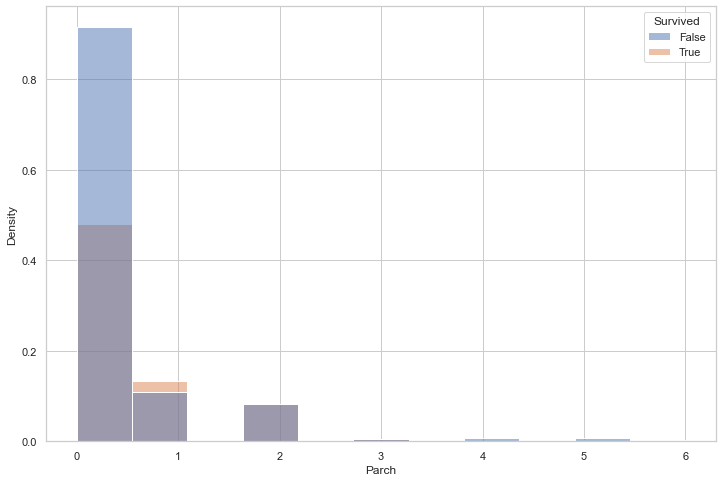

In [584]:
sns.histplot(x='Parch', hue='Survived', stat='density', data=data)

<AxesSubplot:xlabel='FamSize', ylabel='AgeGroup'>

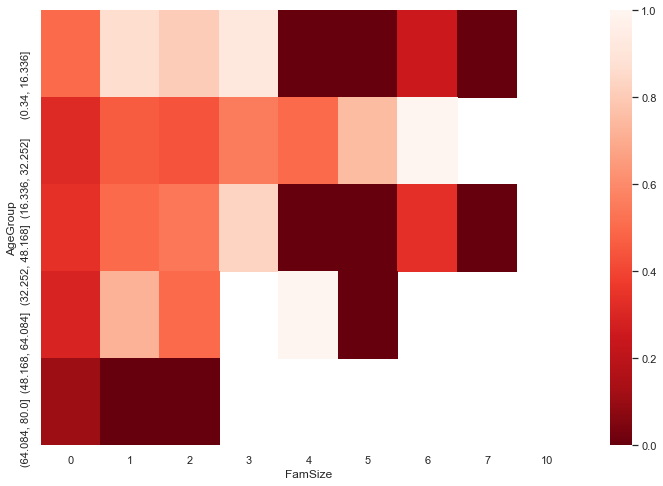

In [585]:
temp = data.copy()
temp['AgeGroup'] = pd.cut(data['Age'], 5)
temp['FamSize'] = temp['Parch'] + temp['SibSp']
temp = temp.groupby(['AgeGroup', 'FamSize'])['Survived'].mean().reset_index()
temp = temp.pivot(index='AgeGroup', columns='FamSize', values='Survived')
sns.heatmap(temp, cmap='Reds_r')

In [586]:
data['Title'] = data['Name'].apply(lambda x: re.split(',|\.', x)[1].strip())
data['Girl'] = (data['Title'] == 'Miss') & (data['Parch'] > 0)
def estimateAgeGroup(X):
    if (X['Title'] == 'Miss') & (X['Parch'] > 0):
        return 'girl'
    elif (X['Title'] == 'Master'):
        return 'boy'
    elif (X['Sex'] == 'male'):
        return 'man'
    else:
        return 'woman'
data['estAgeGroup'] = data.apply(estimateAgeGroup, axis=1)
data.groupby(['estAgeGroup', 'Pclass'])['Age'].mean()

estAgeGroup  Pclass
boy          1          5.306667
             2          2.258889
             3          5.350833
girl         1         21.000000
             2         10.538462
             3          6.903846
man          1         42.382653
             2         33.588889
             3         28.724891
woman        1         37.768116
             2         32.598361
             3         26.828947
Name: Age, dtype: float64

<AxesSubplot:xlabel='FamSize', ylabel='Survived'>

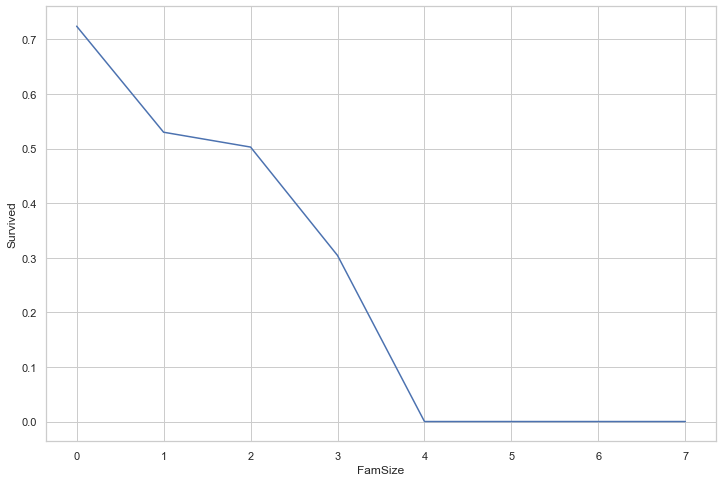

In [587]:
#data['FamSize'] = data['SibSp'].apply(lambda x: x if x > 0 else 2)
data['FamSize'] = abs(4 - (data['SibSp'] + data['Parch'] + 1))
feature = 'FamSize'
temp = data.groupby([feature])['Survived'].mean().reset_index()
sns.lineplot(x=feature, y='Survived', data=temp)

<AxesSubplot:xlabel='Parch', ylabel='SibSp'>

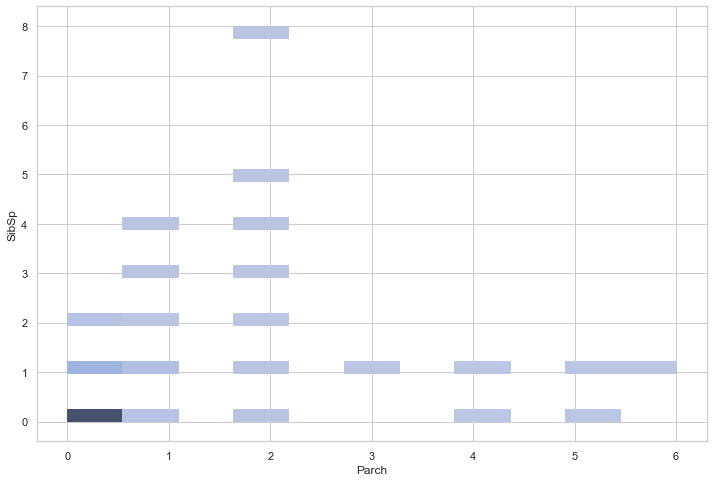

In [588]:
sns.histplot(x='Parch', y='SibSp', data=data[data['Survived']==False])

<AxesSubplot:xlabel='FareAdj', ylabel='Density'>

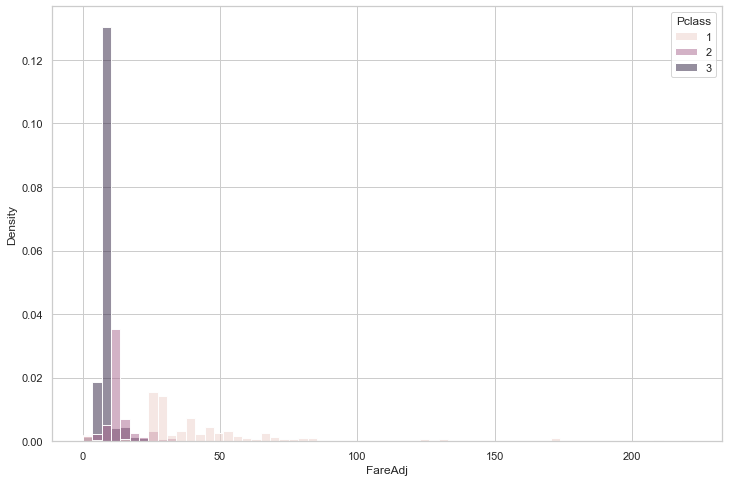

In [589]:
data['x2'] = data['Parch'] + data['SibSp'] + 1 + (data['Age'] / data['Age'].max())
data['TicketFrequency'] = data.groupby('Ticket')['Ticket'].transform('count')
data['FareAdj'] = data['Fare'] / data['TicketFrequency']
sns.histplot(x='FareAdj', hue='Pclass', stat='density', data=data)

In [590]:
maleSurviveWithFam = (data['Sex'] == 'male') & (data['Title'] != 'Master') & (data['Survived'] == 1) & (data['FamSize'] > 1)
data['Surname'] = data['Name'].apply(lambda x: re.split(',', x)[0])
names = data.loc[maleSurviveWithFam, 'Surname']
data['famSurvive'] = data['Surname'].isin(names)
data[(data['famSurvive'] == True) & (data['Sex'] != 'male') ]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,FamSize,Alone,Title,Girl,estAgeGroup,x2,TicketFrequency,FareAdj,Surname,famSurvive
PassengerId,,,,,,,,,,,,,,,,,,,,,
53,True,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,...,2,True,Mrs,False,woman,2.6125,3,25.576400,Harper,True
69,True,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,...,3,False,Miss,True,girl,7.2125,1,7.925000,Andersson,True
114,False,3,"Jussila, Miss. Katriina",female,20.0,1,0,4136,9.8250,NaN,...,2,True,Miss,False,woman,2.2500,1,9.825000,Jussila,True
120,False,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,...,3,False,Miss,True,girl,7.0250,7,4.467857,Andersson,True
231,True,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35.0,1,0,36973,83.4750,C83,...,2,True,Mrs,False,woman,2.4375,2,41.737500,Harris,True
292,True,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,...,2,True,Mrs,False,woman,2.2375,2,45.539600,Bishop,True
403,False,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,...,2,True,Miss,False,woman,2.2625,1,9.825000,Jussila,True
487,True,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0000,C93,...,2,True,Mrs,False,woman,2.4375,2,45.000000,Hoyt,True
542,False,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,...,3,False,Miss,True,girl,7.1125,7,4.467857,Andersson,True


### Surviving males

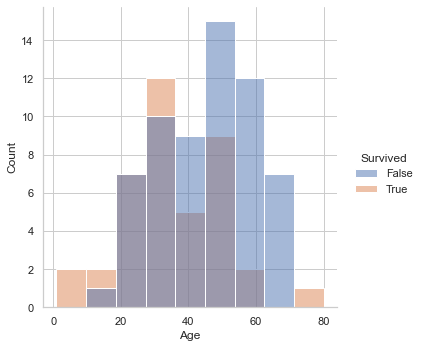

In [591]:
p1Males = data.loc[(data['Sex'] == 'male') & (data['Pclass'] == 1)]
sns.displot(x='Age', hue='Survived', kind='hist', data=p1Males)

 https://medium.com/analytics-vidhya/scikit-learn-pipelines-with-custom-transformer-a-step-by-step-guide-9b9b886fd2cc
        https://stackoverflow.com/questions/48320396/create-a-custom-sklearn-transformermixin-that-transforms-categorical-variables-c

## Model without Maching Learning
  - **Rules**
    - All women and children (individuals with Master title) survive.
    - All men die.
  - Public score of this model: 0.75358

In [12]:
class WCsurvive(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        return self
     
    def predict(self, X):
        X = X.copy()
        X['Title'] = X['Name'].apply(self._getTitle)
        return X.apply(self._rule, axis=1)
    
    def _rule(self, X):
        if (X['Sex'] == 'female') | (X['Title'] == 'Master'):
            return 1
        else:
            return 0
        
    def _getTitle(self, x):
        return re.split(',|\.', x)[1].strip()

In [13]:
trainingScore = WCsurvive().score(data, data['Survived'])
print(f'Training Score: {trainingScore:3.3%}')

Training Score: 79.349%


In [14]:
X_test = pd.read_csv(test, index_col=index, dtype=dtypes)
predictions = WCsurvive().predict(X_test)
submission = pd.DataFrame(
    {'PassengerId':X_test.index,'Survived': predictions})
submission.to_csv('submissionWCsurvive.csv', index=False)